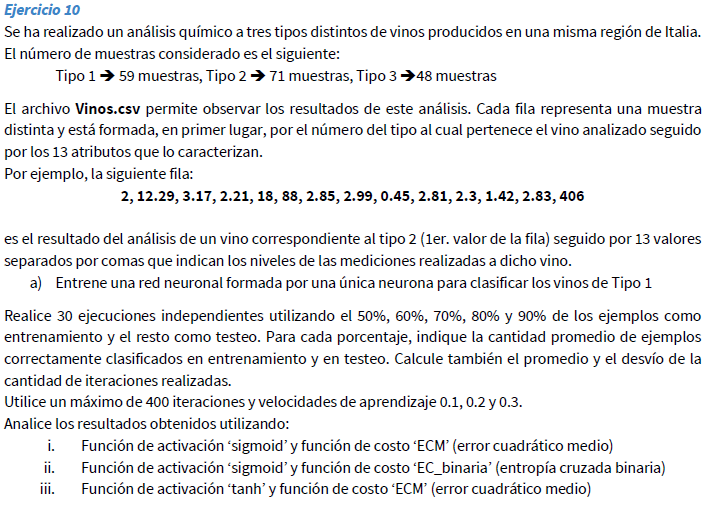

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [4]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos

nombre_archivo = DATOS_DIR + 'Vinos.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'], sep=";")

display(df)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


## Seleccion de atributos y normalizacion

In [7]:
import numpy as np
from sklearn import preprocessing, model_selection

X_raw = np.array(df.iloc[:,1:])  # Recupera todas las columnas excepto la primera
T_raw = np.array(df.iloc[:, 0])    # Recupera la primera columna (es la clase)

clases = np.unique(T_raw)  # obtiene las clases sin repeticiones
print('Las clases del dataset son :', clases)

# Normalizacion con media y desviacion
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X_raw)

Las clases del dataset son : [1 2 3]


## Entrenamiento para Vinos "Tipo 1" con **NeuronaGradiente**

In [50]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np
from ClassNeuronaGral import NeuronaGradiente

def entrenar_neurona_no_lineal(
        t_raw, x_raw,
        error=1e-03, alfa=0.2, fun='sigmoid',
        max_ite=200, corridas=30, test_size=0.4,
        scaler=None, costo="ECM"):
    print('\nNeurona con %s' % fun)
    prom_ite = 0
    prom_acc_train = 0
    prom_acc_test = 0
    veces_train = 0
    veces_test = 0
    for nro_ite in range(corridas):
        # Establece resultado esperado según la clase. 1=clase esperada, 0=otra clase
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_raw, t_raw, test_size=test_size)
        if scaler is not None:
          x_train = scaler.fit_transform(x_train)
          x_test = scaler.transform(x_test)

        # Entrena perceptrón
        modelo = NeuronaGradiente(alpha=alfa, n_iter=max_ite, FUN=fun, cotaE=error, COSTO=costo)
        modelo.fit(x_train, y_train)
        w, b, iteraciones = modelo.w_, modelo.b_, len(modelo.errors_)
        prom_ite += iteraciones
        # efectividad entrenamiento
        y_pred = modelo.predict(x_train)
        efectividad = 100.0 * np.sum(y_train == y_pred) / len(y_pred)
        prom_acc_train += efectividad
        if 100 - efectividad < 0.0000001:
            veces_train += 1
        print("Corrida %2d (E): %6.2f%% de efectividad con %d iteraciones" % (nro_ite+1, efectividad, iteraciones))

        # efectividad prueba
        y_pred = modelo.predict(x_test)
        efectividad = 100.0 * np.sum(y_test == y_pred) / len(y_pred)
        prom_acc_test += efectividad
        if 100 - efectividad < 0.0000001:
            veces_test += 1


    print('Promedio iteraciones  : %6.2f' % (prom_ite / corridas))
    print('Promedio acc. train   : %6.2f' % (prom_acc_train / corridas))
    print('Promedio acc. test    : %6.2f' % (prom_acc_test / corridas))
    print('Ejecuciones train con 100%%  : %3d' % (veces_train))
    print('Ejecuciones test con 100%%  : %3d' % (veces_test))


###############################################################################
# neurona no lineal tanh
ERROR = 1e-03
ALFA = 0.2
FUN = 'sigmoid'
COSTO = "EC_binario"
MAX_ITE = 400
CORRIDAS = 30
TEST_SIZE = .4

cls_name = 1
prom_ite = 0
prom_acc_train = 0
prom_acc_test = 0
veces_train = 0
veces_test = 0

if (FUN == 'tanh'):
    T = 2*(T_raw==cls_name)-1
else:
    T = (T_raw==cls_name)*1

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

# Ejemplo de uso de la función
# Asegúrate de definir T_raw, X_raw, y la clase NeuronaGradiente antes de llamar a la función
entrenar_neurona_no_lineal(T, X_raw,
        error=ERROR, alfa=ALFA, fun=FUN,
        max_ite=MAX_ITE, corridas=CORRIDAS, test_size=TEST_SIZE,
        scaler=scaler, costo=COSTO)



Neurona con sigmoid
Corrida  1 (E): 100.00% de efectividad con 400 iteraciones
Corrida  2 (E): 100.00% de efectividad con 395 iteraciones
Corrida  3 (E): 100.00% de efectividad con 396 iteraciones
Corrida  4 (E): 100.00% de efectividad con 387 iteraciones
Corrida  5 (E): 100.00% de efectividad con 370 iteraciones
Corrida  6 (E): 100.00% de efectividad con 400 iteraciones
Corrida  7 (E): 100.00% de efectividad con 376 iteraciones
Corrida  8 (E): 100.00% de efectividad con 388 iteraciones
Corrida  9 (E): 100.00% de efectividad con 400 iteraciones
Corrida 10 (E): 100.00% de efectividad con 387 iteraciones
Corrida 11 (E): 100.00% de efectividad con 383 iteraciones
Corrida 12 (E): 100.00% de efectividad con 400 iteraciones
Corrida 13 (E): 100.00% de efectividad con 397 iteraciones
Corrida 14 (E): 100.00% de efectividad con 400 iteraciones
Corrida 15 (E): 100.00% de efectividad con 400 iteraciones
Corrida 16 (E): 100.00% de efectividad con 400 iteraciones
Corrida 17 (E): 100.00% de efectivi

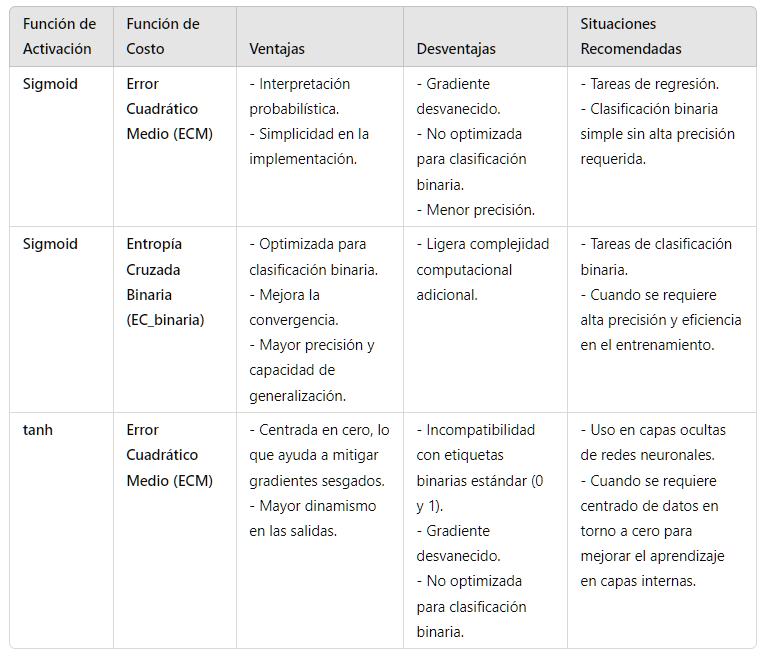